<a href="https://colab.research.google.com/github/caioitalo/soulcode/blob/main/Trab_Final_Consolidado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Turma BC26 - Engenharia de Dados**
## **Projeto final - Tema: Combustíveis**
>**Equipe:**
* Augusto Tonelli
* Caio Alves
* Érica Marçal
* Luan Sagara
* Nayara Bernardo






# **Resumo**

> Projeto Final de Conclusão do Bootcamp de Engenharia de Dados promovido pela Soul Code Academy. 
> 
>
> O tema dado à equipe foi o de **Combustíveis**. Os datasets obtidos foram extraídos desse [link](https://dados.gov.br/dados/organizacoes/visualizar/agencia-nacional-do-petroleo-gas-natural-e-biocombustiveis-anp).
>
>Neste trabalho foi realizado um processo de ETL que contemplou os seguintes aspectos:
- Extração e carregamento de dados brutos para uma máquina **Cloud SQL** com MySQL
- Transformações utilizando **Pandas** e **Pyspark**
- Carregamento dos dados tratados para o **MongoDB** e uma bucket **Cloud Storage**
- Realização de análises a partir queries com **BigQuery**
- Criação de Dashboards com uso do **Google Looker Studio**


#1. EXTRAÇÃO

## 1.1. Instalação e importação de bibliotecas

### 1.1.1. Instalação das bibliotecas

In [1]:
!pip install gcsfs 
!pip install pyspark 
!pip install pymongo 
!pip install pymysql 
!pip install mysql-connector-python 

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 14.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=753636c80b4652f581e60cb5b9f3795abb8785b5c5615fcfa000960cff54e9c9
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 45.9 MB/s eta 0:00:00


### 1.1.2. Importação das bibliotecas

In [18]:
from google.cloud import storage
import os
import mysql.connector
from sqlalchemy import create_engine
import pandas as pd
import matplotlib
import glob
import requests
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pymongo import MongoClient
import pandas_gbq

### 1.1.3. Definição do máximo de colunas a ser mostrada

In [3]:
pd.set_option('display.max_columns',25)

##1.2. Envio dos Datasets brutos ao MySQL e para o Cloud Storage

> **Criação de um dicionário contendo os nomes e links dos Datasets**

In [4]:
dataframes = {'dfbio_bruto':'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/arquivos-producao-de-biocombustiveis/producao-biodiesel-m3-2005-2021.csv',
'dfetanol_bruto':'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/arquivos-producao-de-biocombustiveis/producao-etanol-anidro-hidratado-m3-2012-2022.csv',
'dfpetroleo_bruto':'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/ppgn-el/producao-petroleo-m3-1997-2022.csv',
'dfgas_bruto':'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/ppgn-el/producao-gas-natural-1000m3-1997-2022.csv',
'dfimpexppet_bruto':'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/ie/petroleo/importacoes-exportacoes-petroleo-2000-2022.csv',
'dfimpexpgas_bruto':'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/ie/gn/importacao-gas-natural-2000-2022.csv',
'dfimpexpder_bruto':'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/ie/derivados/importacoes-exportacoes-derivados-2000-2022.csv',
'dfimpexpeta_bruto':'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/ie/etanol/importacoes-exportacoes-etanol-2012-2022.csv',
'dfprodder_bruto':'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/pppd/producao-derivados-petroleo-por-refinaria-m3-1990-2021.csv'}

> **Utilização da biblioteca SQLAlchemy para conexão com o Cloud SQL**

In [5]:
servidor = '34.69.19.129'
nome_do_banco = 'projeto-final'
usuario = 'root'
senha = 'root'

# Criando uma SQLAlchemy engine para conectar com o MySQL 
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=servidor, db=nome_do_banco, user=usuario, pw=senha))


> **Conexão com a Service Account para envio para a Bucket**

In [6]:
serviceAccount = '/content/sc-bc26-ed7-adb0dc2607d9.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

> **Leitura e envio do Datasets brutos para o Cloud SQL e Cloud Storage utilizando Python puro**

In [19]:
for k,v in dataframes.items():
  df_generico = pd.read_csv(v,sep=';')
  df_generico.to_sql(k, engine, index=True, index_label="id", if_exists='replace')
  df_generico.to_csv(f'gs://projeto-final-equipe4/arquivos_brutos/{k}.csv',
                     storage_options={'token':'/content/sc-bc26-ed7-adb0dc2607d9.json'},index=False)

> **Leitura e envio dos datasets de preços (por estarem em .xlsx foram feitos em separado)**

In [ ]:
dfpreco1_bruto = pd.read_excel('https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/shlp/2001-2012/semanal-estados-2004-a-2012.xlsx', header=12)
dfpreco2_bruto = pd.read_excel('https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/shlp/semanal/semanal-estados-desde-2013.xlsx', header = 17)

In [167]:
#dfpreco1_bruto.to_sql('dfpreco0112_bruto', engine, index=True, index_label="id", if_exists='replace')
#dfpreco2_bruto.to_sql('dfpreco13_bruto', engine, index=True, index_label="id", if_exists='replace')
dfpreco1_bruto.to_excel('gs://projeto-final-equipe4/arquivos_brutos/df1preco_bruto.xlsx',
                        storage_options={'token':'/content/sc-bc26-ed7-adb0dc2607d9.json'},header=12, index=False)
dfpreco2_bruto.to_excel('gs://projeto-final-equipe4/arquivos_brutos/df2preco_bruto.xlsx',
                        storage_options={'token':'/content/sc-bc26-ed7-adb0dc2607d9.json'},header=17, index=False)


#2. TRANSFORMAÇÃO

## 2.1. Dataset de Produção de Biocombustíveis

### 2.1.1. Leitura dos datasets

In [52]:
dfbdi = pd.read_csv('https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/dfbio_bruto.csv')
dfeta = pd.read_csv('https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/dfetanol_bruto.csv')

### 2.1.2. Pré-análise dos Dataframes

In [53]:
dfbdi.head(2)

,ANO,MÊS,GRANDE REGIÃO,UNIDADE DA FEDERAÇÃO,PRODUTOR,PRODUTO,PRODUÇÃO
0,2005,ABR,REGIÃO SUL,RIO GRANDE DO SUL,GRANOL (CACHOEIRA DO SUL),BIODIESEL,0
1,2005,MAI,REGIÃO SUL,RIO GRANDE DO SUL,GRANOL (CACHOEIRA DO SUL),BIODIESEL,0


In [54]:
dfeta.head(2)

,ANO,MÊS,GRANDE REGIÃO,UNIDADE DA FEDERAÇÃO,PRODUTO,PRODUÇÃO
0,2012,JAN,REGIÃO NORTE,RONDONIA,ANIDRO,0
1,2012,FEV,REGIÃO NORTE,RONDONIA,ANIDRO,0


### 2.1.3. Tratamentos

> **Drop da coluna de produtor para igualar os Dataframes. Não fará falta nas análises**

In [55]:
dfbdi.drop('PRODUTOR',axis=1,inplace=True)

> **União dos dois dataframes a fim de facilitar o tratamento**

In [56]:
dfbio = pd.concat([dfbdi,dfeta])

> **Check de valores nulos**

In [57]:
dfbio.isna().sum()

ANO                     0
MÊS                     0
GRANDE REGIÃO           0
UNIDADE DA FEDERAÇÃO    0
PRODUTO                 0
PRODUÇÃO                0
dtype: int64

> **Check de colunas e seus tipos**

In [58]:
dfbio.dtypes

ANO                      int64
MÊS                     object
GRANDE REGIÃO           object
UNIDADE DA FEDERAÇÃO    object
PRODUTO                 object
PRODUÇÃO                object
dtype: object

> **Renomeação de colunas**

In [59]:
dfbio.rename(columns={'ANO':'ano','MÊS':'mes','GRANDE REGIÃO':'regiao','UNIDADE DA FEDERAÇÃO':'uf','PRODUTO':'produto','PRODUÇÃO':'volume_m3'},inplace=True)

> **Retirada de acentuação da coluna estado**

In [60]:
dfbio['uf'] = dfbio.uf.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [61]:
dfbio

,ano,mes,regiao,uf,produto,volume_m3
0,2005,ABR,REGIÃO SUL,RIO GRANDE DO SUL,BIODIESEL,0
1,2005,MAI,REGIÃO SUL,RIO GRANDE DO SUL,BIODIESEL,0
2,2005,FEV,REGIÃO SUL,RIO GRANDE DO SUL,BIODIESEL,0
3,2005,MAR,REGIÃO SUL,RIO GRANDE DO SUL,BIODIESEL,0
4,2005,JUN,REGIÃO SUL,RIO GRANDE DO SUL,BIODIESEL,0
...,...,...,...,...,...,...
6937,2022,JUL,REGIÃO NORTE,TOCANTINS,HIDRATADO,"17102,386"
6938,2022,AGO,REGIÃO NORTE,TOCANTINS,HIDRATADO,"14012,163"
6939,2022,SET,REGIÃO NORTE,TOCANTINS,HIDRATADO,"11061,83"
6940,2022,OUT,REGIÃO NORTE,TOCANTINS,HIDRATADO,"11955,529"


> **Restrição do dataframe para o intervalo desejado**

In [62]:
dfbio = dfbio.loc[(dfbio['ano'] >= 2012) & (dfbio['ano'] <= 2021)]

> **Check dos valores únicos de cada coluna para procura de possíveis inconsistências**

Inconsistências encontradas: 
1. Região -> colocar hífen em CENTRO OESTE
2. volume_m3 -> Trocar vírgula para ponto 
3. uf -> colocar acento em GOIAS, PIAUI, PARA, RONDONIA



In [63]:
dfbio.groupby('volume_m3').size()

volume_m3
0           10084
0,001           1
0,003           1
0,005           1
0,015           1
            ...  
9996,297        1
9997,052        1
9998,07         1
9998,268        1
9999,135        1
Length: 7926, dtype: int64

> **Tratamento das inconsistências detectadas**

In [64]:
dfbio.volume_m3.replace(',','.',regex=True, inplace=True)
dfbio.regiao.replace({'REGIÃO CENTRO OESTE':'REGIÃO CENTRO-OESTE'},inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [65]:
dfbio.uf.replace({'BRASILIA':'DISTRITO FEDERAL'},inplace=True)

> **Ajuste da coluna de data unindo as colunas de mês e ano**

In [66]:
dfbio.mes.replace(({'JAN':'01','FEV':'02','MAR':'03','ABR':'04','MAI':'05','JUN':'06','JUL':'07','AGO':'08', 
                    'SET':'09','OUT':'10','NOV':'11','DEZ':'12'}),regex=True,inplace=True)

In [67]:
# Troca do tipo para string, então união das colunas de data e finalmente transformação para o tipo datetime
dfbio['ano'] = dfbio['ano'].astype(str)
dfbio['data'] = dfbio['ano'] + '-' + dfbio['mes']
dfbio['data'] = pd.to_datetime(dfbio['data'], format = '%Y-%m')

<ipython-input-67-1e03f932ab4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbio['ano'] = dfbio['ano'].astype(str)
<ipython-input-67-1e03f932ab4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbio['data'] = dfbio['ano'] + '-' + dfbio['mes']
<ipython-input-67-1e03f932ab4d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [68]:
# Drop das colunas ano e mes, pois não são mais necessárias
dfbio.drop(['ano','mes'],axis=1,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


> **Troca de tipo da coluna volume_m3 para float**

In [69]:
dfbio['volume_m3'] = dfbio['volume_m3'].astype(float)

<ipython-input-69-952a0d619570>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbio['volume_m3'] = dfbio['volume_m3'].astype(float)


In [70]:
dfbio

,regiao,uf,produto,volume_m3,data
8202,REGIÃO SUL,RIO GRANDE DO SUL,BIODIESEL,8965.277,2012-06-01
8203,REGIÃO SUL,RIO GRANDE DO SUL,BIODIESEL,5557.868,2012-07-01
8204,REGIÃO SUL,RIO GRANDE DO SUL,BIODIESEL,14360.758,2012-04-01
8205,REGIÃO SUL,RIO GRANDE DO SUL,BIODIESEL,14726.383,2012-05-01
8206,REGIÃO SUL,RIO GRANDE DO SUL,BIODIESEL,8211.036,2012-08-01
...,...,...,...,...,...
6358,REGIÃO CENTRO-OESTE,DISTRITO FEDERAL,HIDRATADO,0.000,2021-08-01
6359,REGIÃO CENTRO-OESTE,DISTRITO FEDERAL,HIDRATADO,0.000,2021-09-01
6360,REGIÃO CENTRO-OESTE,DISTRITO FEDERAL,HIDRATADO,0.000,2021-10-01
6361,REGIÃO CENTRO-OESTE,DISTRITO FEDERAL,HIDRATADO,0.000,2021-11-01


### 2.1.4. Plots em pandas

> **Produção de álcool anidro durante o período 2012-2021**

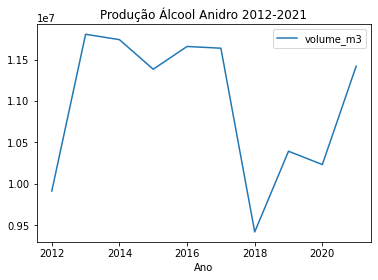

In [71]:
ft1 = dfbio.loc[dfbio['produto'] == 'ANIDRO']
ft1.groupby(dfbio['data'].dt.year).sum().plot.line(title ='Produção Álcool Anidro 2012-2021', xlabel = 'Ano')

> ** **

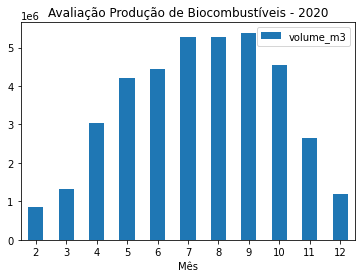

In [72]:
ft = dfbio.loc[(dfbio['data'] > '2020-01-01') & (dfbio['data'] < '2020-12-31') ]
ft.groupby(dfbio['data'].dt.month).sum().plot.bar(title ='Avaliação Produção de Biocombustíveis - 2020', xlabel='Mês',rot=0)

## 2.2. Dataset de Produção de Petróleo e Gás Natural

### 2.2.1. Leitura dos datasets

In [109]:
dfpet = pd.read_csv('https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/dfpetroleo_bruto.csv')
dfgas = pd.read_csv('https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/dfgas_bruto.csv')

### 2.2.2. Pré-analise dos Dataframes

In [110]:
dfgas.head(2)

,ANO,MÊS,GRANDE REGIÃO,UNIDADE DA FEDERAÇÃO,PRODUTO,LOCALIZAÇÃO,PRODUÇÃO
0,1997,JAN,REGIÃO SUDESTE,RIO DE JANEIRO,GÁS NATURAL,MAR,325655
1,1997,FEV,REGIÃO SUDESTE,RIO DE JANEIRO,GÁS NATURAL,MAR,330876


In [111]:
dfpet.head(2)

,ANO,MÊS,GRANDE REGIÃO,UNIDADE DA FEDERAÇÃO,PRODUTO,LOCALIZAÇÃO,PRODUÇÃO
0,1997,JAN,REGIÃO SUDESTE,RIO DE JANEIRO,PETRÓLEO,MAR,2767443
1,1997,FEV,REGIÃO SUDESTE,RIO DE JANEIRO,PETRÓLEO,MAR,2891003


In [112]:
dfpet.dtypes

ANO                      int64
MÊS                     object
GRANDE REGIÃO           object
UNIDADE DA FEDERAÇÃO    object
PRODUTO                 object
LOCALIZAÇÃO             object
PRODUÇÃO                object
dtype: object

In [113]:
dfgas.dtypes

ANO                      int64
MÊS                     object
GRANDE REGIÃO           object
UNIDADE DA FEDERAÇÃO    object
PRODUTO                 object
LOCALIZAÇÃO             object
PRODUÇÃO                object
dtype: object

### 2.2.3. Tratamentos

> **Concatenação dos DFs**

In [114]:
dfgaspet = pd.concat([dfpet, dfgas])

> **Renomeação das colunas**

In [115]:
dfgaspet.rename(columns={'ANO':'ano','MÊS':'mes','GRANDE REGIÃO':'regiao','UNIDADE DA FEDERAÇÃO':'uf',
                         'PRODUTO':'produto','LOCALIZAÇÃO':'localizacao','PRODUÇÃO':'producao'},inplace=True)

In [116]:
dfgaspet

,ano,mes,regiao,uf,produto,localizacao,producao
0,1997,JAN,REGIÃO SUDESTE,RIO DE JANEIRO,PETRÓLEO,MAR,2767443
1,1997,FEV,REGIÃO SUDESTE,RIO DE JANEIRO,PETRÓLEO,MAR,2891003
2,1997,MAR,REGIÃO SUDESTE,RIO DE JANEIRO,PETRÓLEO,MAR,2998305
3,1997,ABR,REGIÃO SUDESTE,RIO DE JANEIRO,PETRÓLEO,MAR,2863184
4,1997,MAI,REGIÃO SUDESTE,RIO DE JANEIRO,PETRÓLEO,MAR,2873644
...,...,...,...,...,...,...,...
6758,2022,JUL,REGIÃO SUDESTE,ESPÍRITO SANTO,GÁS NATURAL,TERRA,2129
6759,2022,AGO,REGIÃO SUDESTE,ESPÍRITO SANTO,GÁS NATURAL,TERRA,2143
6760,2022,SET,REGIÃO SUDESTE,ESPÍRITO SANTO,GÁS NATURAL,TERRA,2275
6761,2022,OUT,REGIÃO SUDESTE,ESPÍRITO SANTO,GÁS NATURAL,TERRA,"2296,21325"


> **Verificação de valores nulos**

In [117]:
dfgaspet.isna().sum()

ano            0
mes            0
regiao         0
uf             0
produto        0
localizacao    0
producao       0
dtype: int64

> **Verificação dados de todas as colunas**

In [118]:
pd.unique(dfgaspet['producao'])

array(['2767443', '2891003', '2998305', ..., '2143', '2296,21325',
       '2124,99039'], dtype=object)

> **Restrição do dataframe para o intervalo desejado**

In [119]:
fano = (dfgaspet.ano > 2011) & (dfgaspet.ano < 2022)
dfgaspet = dfgaspet.loc[fano]

> **Troca do tipo da coluna producao**

In [120]:
dfgaspet.producao.replace(',','.',regex=True,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [121]:
dfgaspet['producao'] = dfgaspet['producao'].astype(float)

<ipython-input-121-e772b7a9a457>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgaspet['producao'] = dfgaspet['producao'].astype(float)


In [122]:
dfgaspet.dtypes

ano              int64
mes             object
regiao          object
uf              object
produto         object
localizacao     object
producao       float64
dtype: object

> **Ajuste da coluna de data unindo as colunas de mês e ano**

In [123]:
dfgaspet.mes.replace(({'JAN':'01','FEV':'02','MAR':'03','ABR':'04','MAI':'05','JUN':'06',
                       'JUL':'07','AGO':'08','SET':'09','OUT':'10','NOV':'11','DEZ':'12'}),inplace=True)

In [124]:
dfgaspet['ano'] = dfgaspet['ano'].astype(str)
dfgaspet['data'] = dfgaspet['ano'] + '-' + dfgaspet['mes']
dfgaspet['data'] = pd.to_datetime(dfgaspet['data'], format = '%Y-%m')

<ipython-input-124-f0f6b8019af4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgaspet['ano'] = dfgaspet['ano'].astype(str)
<ipython-input-124-f0f6b8019af4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgaspet['data'] = dfgaspet['ano'] + '-' + dfgaspet['mes']
<ipython-input-124-f0f6b8019af4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [125]:
dfgaspet.drop(['ano','mes'],axis=1,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [126]:
dfgaspet

,regiao,uf,produto,localizacao,producao,data
3960,REGIÃO NORDESTE,RIO GRANDE DO NORTE,PETRÓLEO,MAR,37112.66700,2012-01-01
3961,REGIÃO NORDESTE,RIO GRANDE DO NORTE,PETRÓLEO,MAR,35205.35900,2012-02-01
3962,REGIÃO NORDESTE,RIO GRANDE DO NORTE,PETRÓLEO,MAR,36234.85900,2012-03-01
3963,REGIÃO NORDESTE,RIO GRANDE DO NORTE,PETRÓLEO,MAR,36118.59800,2012-04-01
3964,REGIÃO NORDESTE,RIO GRANDE DO NORTE,PETRÓLEO,MAR,36591.28700,2012-05-01
...,...,...,...,...,...,...
6516,REGIÃO SUDESTE,ESPÍRITO SANTO,GÁS NATURAL,TERRA,1894.26625,2021-08-01
6517,REGIÃO SUDESTE,ESPÍRITO SANTO,GÁS NATURAL,TERRA,1795.55080,2021-09-01
6518,REGIÃO SUDESTE,ESPÍRITO SANTO,GÁS NATURAL,TERRA,1764.21733,2021-10-01
6519,REGIÃO SUDESTE,ESPÍRITO SANTO,GÁS NATURAL,TERRA,1676.85354,2021-11-01


> **Group By para verificar produtos**

In [127]:

dfgaspet.groupby(['produto']).size().sort_values(ascending=False)

produto
PETRÓLEO       2640
GÁS NATURAL    2635
dtype: int64

## 2.3. Dataset de Produção derivados de Petróleo

### 2.3.1. Leitura dos Datasets

In [74]:
dfder = pd.read_csv('https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/dfprodder_bruto.csv')

### 2.3.2. Pré-análise dos Dataframes

In [75]:
dfder.head(2)

,ANO,MÊS,UNIDADE DA FEDERAÇÃO,REFINARIA,PRODUTO,PRODUÇÃO
0,1990,OUT,SÃO PAULO,RPBC,GASOLINA DE AVIAÇÃO,2076
1,1990,SET,SÃO PAULO,RPBC,GASOLINA DE AVIAÇÃO,3404


In [76]:
dfder.isna().sum()

ANO                     0
MÊS                     0
UNIDADE DA FEDERAÇÃO    0
REFINARIA               0
PRODUTO                 0
PRODUÇÃO                0
dtype: int64

### 2.3.3. Tratamentos

> **Renomeação das colunas**

In [77]:
dfder.rename(columns={'ANO':'ano','MÊS':'mes','UNIDADE DA FEDERAÇÃO':'uf','REFINARIA':'refinaria','PRODUTO':'produto','PRODUÇÃO':'producao'},inplace=True)

> **Procura de inconsistências com unique em cada coluna**


In [78]:
pd.unique(dfder['produto'])

array(['GASOLINA DE AVIAÇÃO', 'ÓLEO COMBUSTÍVEL', 'NAFTA',
       'OUTROS NÃO ENERGÉTICOS', 'ASFALTO', 'COQUE', 'OUTROS ENERGÉTICOS',
       'QUEROSENE ILUMINANTE', 'LUBRIFICANTE', 'QUEROSENE DE AVIAÇÃO',
       'ÓLEO DIESEL', 'SOLVENTE', 'PARAFINA', 'GLP', 'GASOLINA A'],
      dtype=object)

> **Filtragem de linhas com somente os produtos que interessam ao escopo**

In [79]:
dfder = dfder.loc[(dfder['produto'] == 'OUTROS ENERGÉTICOS') | (dfder['produto'] == 'COQUE') | (dfder['produto'] == 'GASOLINA A') |
                  (dfder['produto'] == 'ÓLEO COMBUSTÍVEL') | (dfder['produto'] == 'GASOLINA DE AVIAÇÃO') | 
                  (dfder['produto'] == 'ÓLEO DIESEL') | (dfder['produto'] == 'GLP') | (dfder['produto'] == 'QUEROSENE DE AVIAÇÃO')]

> **Restrição do dataframe para o intervalo desejado**

In [80]:
# Filtro ano 2012 a 2021
fano = (dfder.ano > 2011) & (dfder.ano < 2022)
dfder = dfder.loc[fano]

> **Replace de vírgula por ponto para conseguir transformar a coluna para float**

In [81]:
dfder.replace([','],'.',regex=True,inplace=True)

In [82]:
dfder['producao'] = dfder['producao'].astype(float)

In [83]:
dfder.dtypes

ano            int64
mes           object
uf            object
refinaria     object
produto       object
producao     float64
dtype: object

> **Ajuste da coluna de data unindo as colunas de mês e ano**

In [84]:
# Mudança de letras para números do mês
dfder.mes.replace(({'JAN':'01','FEV':'02','MAR':'03','ABR':'04','MAI':'05','JUN':'06',
                 'JUL':'07','AGO':'08','SET':'09','OUT':'10','NOV':'11','DEZ':'12'}),regex=True,inplace=True)

In [85]:
# Transformação coluna ano para string
dfder['ano'] = dfder['ano'].astype(str)

In [86]:
# Junção colunas 'ano' e 'mes'
dfder['data'] = dfder['ano'] + '-' + dfder['mes']

In [87]:
# Transformação da coluna 'data' para DateTime
dfder['data'] = pd.to_datetime(dfder['data'], format = '%Y-%m')

In [88]:
dfder

,ano,mes,uf,refinaria,produto,producao,data
68343,2012,01,AMAZONAS,REMAN,OUTROS ENERGÉTICOS,8702.0,2012-01-01
68344,2012,10,AMAZONAS,REMAN,OUTROS ENERGÉTICOS,0.0,2012-10-01
68345,2012,09,AMAZONAS,REMAN,OUTROS ENERGÉTICOS,16680.0,2012-09-01
68346,2012,08,AMAZONAS,REMAN,OUTROS ENERGÉTICOS,106.0,2012-08-01
68347,2012,01,CEARÁ,LUBNOR,OUTROS ENERGÉTICOS,0.0,2012-01-01
...,...,...,...,...,...,...,...
99810,2021,10,SÃO PAULO,SSOIL,QUEROSENE DE AVIAÇÃO,0.0,2021-10-01
99811,2021,09,SÃO PAULO,SSOIL,QUEROSENE DE AVIAÇÃO,0.0,2021-09-01
99812,2021,08,SÃO PAULO,SSOIL,QUEROSENE DE AVIAÇÃO,0.0,2021-08-01
99814,2021,12,SÃO PAULO,SSOIL,QUEROSENE DE AVIAÇÃO,0.0,2021-12-01


> **Organizando e dropando colunas de mes e ano, pois já existe a de data**

In [89]:
dfder = dfder[['data','uf','refinaria','produto','producao']]

In [90]:
dfder

,data,uf,refinaria,produto,producao
68343,2012-01-01,AMAZONAS,REMAN,OUTROS ENERGÉTICOS,8702.0
68344,2012-10-01,AMAZONAS,REMAN,OUTROS ENERGÉTICOS,0.0
68345,2012-09-01,AMAZONAS,REMAN,OUTROS ENERGÉTICOS,16680.0
68346,2012-08-01,AMAZONAS,REMAN,OUTROS ENERGÉTICOS,106.0
68347,2012-01-01,CEARÁ,LUBNOR,OUTROS ENERGÉTICOS,0.0
...,...,...,...,...,...
99810,2021-10-01,SÃO PAULO,SSOIL,QUEROSENE DE AVIAÇÃO,0.0
99811,2021-09-01,SÃO PAULO,SSOIL,QUEROSENE DE AVIAÇÃO,0.0
99812,2021-08-01,SÃO PAULO,SSOIL,QUEROSENE DE AVIAÇÃO,0.0
99814,2021-12-01,SÃO PAULO,SSOIL,QUEROSENE DE AVIAÇÃO,0.0


## 2.4. Dataset de Importação e Exportação de combustíveis

###2.4.1. Leitura dos datasets

In [212]:
def baixar_arquivo(url, endereco=None):
    if endereco is None:
        endereco = os.path.basename(url.split("?")[0])
    resposta = requests.get(url, stream=True)
    if resposta.status_code == requests.codes.OK:
        with open(endereco, 'wb') as novo_arquivo:
            for parte in resposta.iter_content(chunk_size=256):
                novo_arquivo.write(parte)
        print("Download finalizado. Arquivo salvo em: {}".format(endereco))
    else:
        resposta.raise_for_status()

def selecionar_arquivos_para_baixar(): 
    import_export_01 = "https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/dfimpexppet_bruto.csv"
    import_export_02 = "https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/dfimpexpgas_bruto.csv"
    import_export_03 = "https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/dfimpexpder_bruto.csv"
    import_export_04 = "https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/dfimpexpeta_bruto.csv"

    baixar_arquivo(import_export_01, "/content/import_export_01.csv")
    baixar_arquivo(import_export_02, "/content/import_export_02.csv")
    baixar_arquivo(import_export_03, "/content/import_export_03.csv")
    baixar_arquivo(import_export_04, "/content/import_export_04.csv")

In [213]:
selecionar_arquivos_para_baixar()

Download finalizado. Arquivo salvo em: /content/import_export_01.csv
Download finalizado. Arquivo salvo em: /content/import_export_02.csv
Download finalizado. Arquivo salvo em: /content/import_export_03.csv
Download finalizado. Arquivo salvo em: /content/import_export_04.csv


> **Carregamento dos arquivos baixados e concantenados em um único Dataframe**

In [214]:
def carregar_dados_geral():
    caminho = r'/content'
    todos_os_arquivos = glob.glob(caminho + "/*.csv")
    li = []

    for nome_arquivo in todos_os_arquivos:
        df = pd.read_csv(nome_arquivo, encoding="UTF-8")
        df.rename(columns={'IMPORTADO':'IMPORTADO / EXPORTADO', 'DISPÊNDIO':'DISPÊNDIO / RECEITA'}, inplace=True)
        li.append(df)

    dfimex = pd.concat(li)
    return dfimex

In [215]:
dfimex = carregar_dados_geral()

In [216]:
dfimex.head()

,ANO,MÊS,PRODUTO,OPERAÇÃO COMERCIAL,IMPORTADO / EXPORTADO,DISPÊNDIO / RECEITA
0,2000,ABR,ASFALTO,EXPORTAÇÃO,"1362,035577",309443
1,2000,AGO,ASFALTO,EXPORTAÇÃO,"2700,793269",544917
2,2000,DEZ,ASFALTO,EXPORTAÇÃO,"1839,723077",426760
3,2000,FEV,ASFALTO,EXPORTAÇÃO,"1676,491346",270633
4,2000,JAN,ASFALTO,EXPORTAÇÃO,"1702,567308",360648


### 2.4.2 Pré-análise do dataframe

In [217]:
dfimex.shape

(9584, 6)

In [218]:
dfimex.isna().sum()

ANO                       0
MÊS                       0
PRODUTO                   0
OPERAÇÃO COMERCIAL        0
IMPORTADO / EXPORTADO    11
DISPÊNDIO / RECEITA       0
dtype: int64

> **Checagem de linhas com valores nulos**

In [219]:
dfimex[dfimex['IMPORTADO / EXPORTADO'].isna()]

,ANO,MÊS,PRODUTO,OPERAÇÃO COMERCIAL,IMPORTADO / EXPORTADO,DISPÊNDIO / RECEITA
7821,2021,ABR,QUEROSENE ILUMINANTE,IMPORTAÇÃO,NaN,0
7822,2021,AGO,QUEROSENE ILUMINANTE,IMPORTAÇÃO,NaN,0
7824,2021,FEV,QUEROSENE ILUMINANTE,IMPORTAÇÃO,NaN,0
7825,2021,JAN,QUEROSENE ILUMINANTE,IMPORTAÇÃO,NaN,0
7826,2021,JUL,QUEROSENE ILUMINANTE,IMPORTAÇÃO,NaN,0
7827,2021,JUN,QUEROSENE ILUMINANTE,IMPORTAÇÃO,NaN,0
7828,2021,MAI,QUEROSENE ILUMINANTE,IMPORTAÇÃO,NaN,0
7829,2021,MAR,QUEROSENE ILUMINANTE,IMPORTAÇÃO,NaN,0
7830,2021,NOV,QUEROSENE ILUMINANTE,IMPORTAÇÃO,NaN,0
7831,2021,OUT,QUEROSENE ILUMINANTE,IMPORTAÇÃO,NaN,0


> **Checagem de inconsistências de colunas**

In [220]:
dfimex.groupby('PRODUTO').size()

PRODUTO
ASFALTO                        550
COMBUSTÍVEIS PARA AERONAVES    275
COMBUSTÍVEIS PARA NAVIOS       275
COQUE                          550
ETANOL ANIDRO                  262
ETANOL HIDRATADO               262
GASOLINA A                     548
GASOLINA DE AVIAÇÃO            547
GLP                            550
GÁS NATURAL                    275
LUBRIFICANTE                   550
NAFTA                          547
OUTROS NÃO ENERGÉTICOS         550
PARAFINA                       550
PETRÓLEO                       550
QUEROSENE DE AVIAÇÃO           549
QUEROSENE ILUMINANTE           546
SOLVENTE                       550
ÓLEO COMBUSTÍVEL               550
ÓLEO DIESEL                    548
dtype: int64

### 2.4.3 Tratamentos

> **Filtragem de linhas com somente os produtos que interessam ao escopo**

In [221]:
dfimex = dfimex.loc[(dfimex['PRODUTO'] == 'COMBUSTÍVEIS PARA AERONAVES') | 
                    (dfimex['PRODUTO'] == 'COMBUSTÍVEIS PARA NAVIOS') | 
                    (dfimex['PRODUTO'] == 'COQUE') | (dfimex['PRODUTO'] == 'ETANOL ANIDRO') | 
                    (dfimex['PRODUTO'] == 'ETANOL HIDRATADO') | (dfimex['PRODUTO'] == 'GASOLINA A') |
                    (dfimex['PRODUTO'] == 'GÁS NATURAL') | (dfimex['PRODUTO'] == 'PETRÓLEO') | 
                    (dfimex['PRODUTO'] == 'QUEROSENE DE AVIAÇÃO') | (dfimex['PRODUTO'] == 'ÓLEO COMBUSTÍVEL') | 
                    (dfimex['PRODUTO'] == 'ÓLEO DIESEL') | (dfimex['PRODUTO'] == 'GLP') | 
                    (dfimex['PRODUTO'] == 'GASOLINA DE AVIAÇÃO')]

In [222]:
dfimex.dtypes

ANO                       int64
MÊS                      object
PRODUTO                  object
OPERAÇÃO COMERCIAL       object
IMPORTADO / EXPORTADO    object
DISPÊNDIO / RECEITA      object
dtype: object

> **Transformação da coluna data unindo mes e ano**

In [223]:
dfimex['ANO'] = dfimex['ANO'].astype(str)

In [224]:
dfimex.MÊS.replace(({'JAN':'01','FEV':'02','MAR':'03','ABR':'04','MAI':'05','JUN':'06',
                     'JUL':'07','AGO':'08','SET':'09','OUT':'10','NOV':'11','DEZ':'12'}),regex=True,inplace=True)

In [225]:
# Junção colunas 'ano' e 'mes'
dfimex['DATA'] = dfimex['ANO'] + '-' + dfimex['MÊS']

In [226]:
# Transformação da coluna 'data' para DateTime
dfimex['DATA'] = pd.to_datetime(dfimex['DATA'], format = '%Y-%m')

> **Renomeação das colunas**

In [227]:
dfimex.rename(columns={'IMPORTADO / EXPORTADO':'importado_exportado',
                       'DISPÊNDIO / RECEITA':'dispendio_receita',
                       'OPERAÇÃO COMERCIAL':'operacao_comercial',
                       'DATA':'data',
                       'PRODUTO':'produto'}, inplace=True)

> **Replace vírgula por ponto para conseguir transformar a coluna para float**

In [228]:
dfimex.replace([','],'.',regex=True,inplace=True)

In [229]:
dfimex['importado_exportado'] = dfimex['importado_exportado'].astype(float)

In [230]:
dfimex.drop(columns=['ANO', 'MÊS'], inplace=True)

In [231]:
dfimex.dtypes

produto                        object
operacao_comercial             object
importado_exportado           float64
dispendio_receita              object
data                   datetime64[ns]
dtype: object

> **Filtragem de linhas com somente os anos que interessam ao escopo**

In [232]:
dfimex = dfimex[(dfimex['data'].dt.year >= 2012) & (dfimex['data'].dt.year <= 2021)]

In [233]:
#Reorganização das colunas
dfimex = dfimex[['data','produto','operacao_comercial','importado_exportado','dispendio_receita']]

In [234]:
dfimex

,data,produto,operacao_comercial,importado_exportado,dispendio_receita
4342,2012-04-01,COMBUSTÍVEIS PARA AERONAVES,EXPORTAÇÃO,2.104625e+05,202382171
4343,2012-08-01,COMBUSTÍVEIS PARA AERONAVES,EXPORTAÇÃO,2.023550e+05,171580457
4344,2012-12-01,COMBUSTÍVEIS PARA AERONAVES,EXPORTAÇÃO,2.360711e+05,217700307
4345,2012-02-01,COMBUSTÍVEIS PARA AERONAVES,EXPORTAÇÃO,2.228990e+05,205802941
4346,2012-01-01,COMBUSTÍVEIS PARA AERONAVES,EXPORTAÇÃO,2.791960e+05,251912970
...,...,...,...,...,...
259,2021-05-01,GÁS NATURAL,IMPORTAÇÃO,1.063879e+06,231495337.8
260,2021-03-01,GÁS NATURAL,IMPORTAÇÃO,1.193271e+06,231939438.1
261,2021-11-01,GÁS NATURAL,IMPORTAÇÃO,1.549601e+06,1061285294
262,2021-10-01,GÁS NATURAL,IMPORTAÇÃO,1.870830e+06,1057158888


### 2.4.4. Plots em Pandas

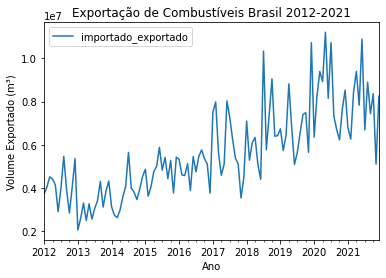

In [235]:
ft = dfimex.loc[dfimex.operacao_comercial == 'EXPORTAÇÃO']
ft.groupby('data').sum().plot.line(title='Exportação de Combustíveis Brasil 2012-2021',xlabel='Ano',ylabel='Volume Exportado (m³)')

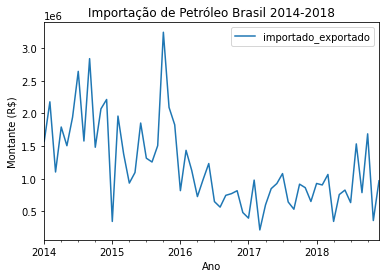

In [236]:
ft = dfimex.loc[(dfimex.operacao_comercial == 'IMPORTAÇÃO') & (dfimex.produto == 'PETRÓLEO') & 
                (dfimex.data.dt.year >= 2014) & (dfimex.data.dt.year <= 2018)]
ft.groupby('data').sum().plot.line(title='Importação de Petróleo Brasil 2014-2018',
                                   xlabel='Ano',ylabel= 'Montante (R$)')

## 2.5. Dataset de Preços de Combustíveis

### 2.5.1. Leitura dos datasets

In [14]:
# Cria a sessão spark
spark = (SparkSession.builder.
         master('local').
         appName('structtype').
         getOrCreate())

In [15]:
spark 

> **Construção do esquema com o Struct Type**

In [16]:
schemat = StructType([StructField('DATA INICIAL', DateType(), True),
                     StructField('DATA FINAL', DateType(), True),
                     StructField('REGIÃO', StringType(), True),
                     StructField('ESTADO', StringType(), True),
                     StructField('PRODUTO', StringType(), True),
                     StructField('NÚMERO DE POSTOS PESQUISADOS', IntegerType(), True),
                     StructField('UNIDADE DE MEDIDA', StringType(), True),
                     StructField('PREÇO MÉDIO REVENDA', FloatType(), True),
                     StructField('DESVIO PADRÃO REVENDA', FloatType(), True),
                     StructField('PREÇO MÍNIMO REVENDA', FloatType(), True),
                     StructField('PREÇO MÁXIMO REVENDA', FloatType(), True),
                     StructField('MARGEM MÉDIA REVENDA', StringType(), True),
                     StructField('COEF DE VARIAÇÃO REVENDA', FloatType(), True),
                     StructField('PREÇO MÉDIO DISTRIBUIÇÃO', StringType(), True),
                     StructField('DESVIO PADRÃO DISTRIBUIÇÃO', StringType(), True),
                     StructField('PREÇO MÍNIMO DISTRIBUIÇÃO', StringType(), True),
                     StructField('PREÇO MÁXIMO DISTRIBUIÇÃO', StringType(), True),
                     StructField('COEF DE VARIAÇÃO DISTRIBUIÇÃO', StringType(), True)])

> **Leitura dos datasets com a aplicação do schema acima**

In [170]:
dft = pd.read_excel('https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/df1preco_bruto.xlsx',usecols='B:S')
dfpreco1 = spark.createDataFrame(dft, schema=schemat)

dft = pd.read_excel('https://storage.googleapis.com/projeto-final-equipe4/arquivos_brutos/df2preco_bruto.xlsx',usecols='B:S')
dfpreco2 = spark.createDataFrame(dft, schema=schemat)


### 2.5.2. Pré-análise do dataframe

In [171]:
dfpreco1.show(2)

+------------+----------+------------+----------------+----------------+----------------------------+-----------------+-------------------+---------------------+--------------------+--------------------+--------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-----------------------------+
|DATA INICIAL|DATA FINAL|      REGIÃO|          ESTADO|         PRODUTO|NÚMERO DE POSTOS PESQUISADOS|UNIDADE DE MEDIDA|PREÇO MÉDIO REVENDA|DESVIO PADRÃO REVENDA|PREÇO MÍNIMO REVENDA|PREÇO MÁXIMO REVENDA|MARGEM MÉDIA REVENDA|COEF DE VARIAÇÃO REVENDA|PREÇO MÉDIO DISTRIBUIÇÃO|DESVIO PADRÃO DISTRIBUIÇÃO|PREÇO MÍNIMO DISTRIBUIÇÃO|PREÇO MÁXIMO DISTRIBUIÇÃO|COEF DE VARIAÇÃO DISTRIBUIÇÃO|
+------------+----------+------------+----------------+----------------+----------------------------+-----------------+-------------------+---------------------+--------------------+--------------------+--------------------+--------

In [172]:
dfpreco2.show(2)

+------------+----------+--------+-------+----------------+----------------------------+-----------------+-------------------+---------------------+--------------------+--------------------+--------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-----------------------------+
|DATA INICIAL|DATA FINAL|  REGIÃO| ESTADO|         PRODUTO|NÚMERO DE POSTOS PESQUISADOS|UNIDADE DE MEDIDA|PREÇO MÉDIO REVENDA|DESVIO PADRÃO REVENDA|PREÇO MÍNIMO REVENDA|PREÇO MÁXIMO REVENDA|MARGEM MÉDIA REVENDA|COEF DE VARIAÇÃO REVENDA|PREÇO MÉDIO DISTRIBUIÇÃO|DESVIO PADRÃO DISTRIBUIÇÃO|PREÇO MÍNIMO DISTRIBUIÇÃO|PREÇO MÁXIMO DISTRIBUIÇÃO|COEF DE VARIAÇÃO DISTRIBUIÇÃO|
+------------+----------+--------+-------+----------------+----------------------------+-----------------+-------------------+---------------------+--------------------+--------------------+--------------------+------------------------+----------------------

### 2.5.3. Tratamentos

> **Unindo os dois Dataframes, pois têm as mesmas colunas**

In [173]:
dfpreco = dfpreco1.union(dfpreco2)

In [174]:
dfpreco.dtypes

[('DATA INICIAL', 'date'),
 ('DATA FINAL', 'date'),
 ('REGIÃO', 'string'),
 ('ESTADO', 'string'),
 ('PRODUTO', 'string'),
 ('NÚMERO DE POSTOS PESQUISADOS', 'int'),
 ('UNIDADE DE MEDIDA', 'string'),
 ('PREÇO MÉDIO REVENDA', 'float'),
 ('DESVIO PADRÃO REVENDA', 'float'),
 ('PREÇO MÍNIMO REVENDA', 'float'),
 ('PREÇO MÁXIMO REVENDA', 'float'),
 ('MARGEM MÉDIA REVENDA', 'string'),
 ('COEF DE VARIAÇÃO REVENDA', 'float'),
 ('PREÇO MÉDIO DISTRIBUIÇÃO', 'string'),
 ('DESVIO PADRÃO DISTRIBUIÇÃO', 'string'),
 ('PREÇO MÍNIMO DISTRIBUIÇÃO', 'string'),
 ('PREÇO MÁXIMO DISTRIBUIÇÃO', 'string'),
 ('COEF DE VARIAÇÃO DISTRIBUIÇÃO', 'string')]

In [ ]:
backup = dfpreco

> **Seleção do período definido para o escopo do projeto**

In [175]:
dfpreco = dfpreco.filter(F.col('DATA INICIAL') >= '2012-01-01')

> **Remoção uma data que não será usada**

In [176]:
dfpreco = dfpreco.drop('DATA FINAL')

> **Renomeção das colunas**

In [177]:
dfpreco = dfpreco.withColumnRenamed('DATA INICIAL','data')\
.withColumnRenamed('REGIÃO','regiao')\
.withColumnRenamed('ESTADO','estado')\
.withColumnRenamed('PRODUTO','produto')\
.withColumnRenamed('NÚMERO DE POSTOS PESQUISADOS','postos_pesquisados')\
.withColumnRenamed('UNIDADE DE MEDIDA','uni_medida')\
.withColumnRenamed('PREÇO MÉDIO REVENDA','media_rev')\
.withColumnRenamed('DESVIO PADRÃO REVENDA','desvio_rev')\
.withColumnRenamed('PREÇO MÍNIMO REVENDA','preco_min_rev')\
.withColumnRenamed('PREÇO MÁXIMO REVENDA','preco_max_rev')\
.withColumnRenamed('MARGEM MÉDIA REVENDA','margem_rev')\
.withColumnRenamed('COEF DE VARIAÇÃO REVENDA','coef_var_rev')\
.withColumnRenamed('PREÇO MÉDIO DISTRIBUIÇÃO','media_dist')\
.withColumnRenamed('DESVIO PADRÃO DISTRIBUIÇÃO','dp_dist')\
.withColumnRenamed('PREÇO MÍNIMO DISTRIBUIÇÃO','preco_min_dist')\
.withColumnRenamed('PREÇO MÁXIMO DISTRIBUIÇÃO','preco_max_dist')\
.withColumnRenamed('COEF DE VARIAÇÃO DISTRIBUIÇÃO','coef_var_dist')

> **Conversão de tipos de colunas**

In [178]:
# Inserção do nome de todas as colunas que deveriam ser float mas são string em uma lista
colunas = ['margem_rev', 'media_dist', 'dp_dist', 
           'preco_min_dist', 'preco_max_dist', 'coef_var_dist']

# Substituição de todas as strings '-' por 0
for i in colunas:
    dfpreco = dfpreco.withColumn(i, F.regexp_replace(i, '-', '0'))

dfpreco = dfpreco.withColumn("margem_rev",F.col("margem_rev").cast(FloatType()))\
                 .withColumn("media_dist",F.col("media_dist").cast(FloatType()))\
                 .withColumn("dp_dist",F.col("dp_dist").cast(FloatType()))\
                 .withColumn("preco_min_dist",F.col("preco_min_dist").cast(FloatType()))\
                 .withColumn("preco_max_dist",F.col("preco_max_dist").cast(FloatType()))\
                 .withColumn("coef_var_dist",F.col("coef_var_dist").cast(FloatType()))

In [179]:
dfpreco.dtypes

[('data', 'date'),
 ('regiao', 'string'),
 ('estado', 'string'),
 ('produto', 'string'),
 ('postos_pesquisados', 'int'),
 ('uni_medida', 'string'),
 ('media_rev', 'float'),
 ('desvio_rev', 'float'),
 ('preco_min_rev', 'float'),
 ('preco_max_rev', 'float'),
 ('margem_rev', 'float'),
 ('coef_var_rev', 'float'),
 ('media_dist', 'float'),
 ('dp_dist', 'float'),
 ('preco_min_dist', 'float'),
 ('preco_max_dist', 'float'),
 ('coef_var_dist', 'float')]

> **Checagem de inconsistências nas colunas**

In [180]:
dfpreco.select('margem_rev').distinct().show()

+----------+
|margem_rev|
+----------+
|     0.202|
|     0.279|
|     0.388|
|     6.528|
|      8.26|
|     5.859|
|     7.243|
|     0.189|
|     0.265|
|     0.115|
|     9.431|
|     5.931|
|     9.494|
|     9.997|
|    11.561|
|     13.03|
|     7.891|
|     10.51|
|      4.96|
|     0.474|
+----------+
only showing top 20 rows



> **Tratamento de inconsistências**

In [181]:
#transforma 'kg' em 'Kg'
dfpreco = dfpreco.withColumn('uni_medida', F.regexp_replace('uni_medida', 'kg', 'Kg'))

In [182]:
#transforma 'OLEO DIESEL' em 'ÓLEO DIESEL'
dfpreco = dfpreco.withColumn('produto', F.regexp_replace('produto', 'OLEO DIESEL', 'ÓLEO DIESEL'))

#3. CARREGAMENTO

> **Conexão à Conta de Serviço atrelada ao Bucket utilizando as crendenciais dela com uma chave json**

In [ ]:
# Conexão à Conta de Serviço atrelada ao bucket utilizando a chave json
serviceAccount = '/content/sc-bc26-ed7-adb0dc2607d9.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

## 3.1. Carregamento Dataframe de Produção de biocombustível para o Cloud Storage

In [ ]:
dfbio.to_csv('gs://projeto-final-equipe4/arquivos_trat/dfbio_trat',
               storage_options={'token':'/content/sc-bc26-ed7-adb0dc2607d9.json',index=False})

## 3.2 Carregamento Dataframe de Produção de Petróleo e Gás Natural para o Cloud Storage

In [ ]:
dfgaspet.to_csv('gs://projeto-final-equipe4/arquivos_trat/dfproducaopetgas_trat',
               storage_options={'token':'/content/sc-bc26-ed7-adb0dc2607d9.json',index=False})

## 3.3 Carregamento Dataframe de Produção de Derivados de Petróleo

In [ ]:
dfder.to_csv('gs://projeto-final-equipe4/arquivos_trat/dfderivados_trat',
               storage_options={'token':'/content/sc-bc26-ed7-adb0dc2607d9.json',index=False})

## 3.4. Carregamento Dataframe de Importações e Exportações de Combustíveis

In [ ]:
dfimex.to_csv('gs://projeto-final-equipe4/arquivos_trat/dfimport-export_trat.csv',
               storage_options={'token':'/content/sc-bc26-ed7-adb0dc2607d9.json',index=False})

## 3.5. Carregamento Dataframe da Série História de Preços de Combustíveis 

In [186]:
dfPandas=dfpreco.toPandas()
dfPandas.to_csv('gs://projeto-final-equipe4/arquivos_trat/dfprecos.csv', storage_options={'token':'/content/sc-bc26-ed7-adb0dc2607d9.json'},index=False)

## 3.6. Carregamento para o mongoDB

> **Conexão ao usuário MongoDB a partir de certificado X.509**

In [246]:
uri = "mongodb+srv://erica-soulcode.7jfrfcs.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client = MongoClient(uri,tls=True,tlsCertificateKeyFile='/content/X509-cert-8089168769125785989.pem')

db = client['projeto_final_combustiveis_viacolab']

> **Utilização de python puro para inserir e checar se os dados tratados foram enviados**

In [249]:
datasets = ['dfderivados_trat','dfbio_trat','dfproducaopetgas_trat']

for x in datasets:
  colecao = db[f'{x}ado']
  df = pd.read_csv(f'https://storage.googleapis.com/projeto-final-equipe4/arquivos_trat/{x}')
  df_dict = df.to_dict('records')
  colecao.insert_many(df_dict)
  print(f'Database "{x}" adicionado ao mongoDB. Número de documentos criados: {colecao.count_documents({})}')

Database "dfderivados_trat" adicionado ao mongoDB. Número de documentos criados: 17264
Database "dfbio_trat" adicionado ao mongoDB. Número de documentos criados: 18051
Database "dfproducaopetgas_trat" adicionado ao mongoDB. Número de documentos criados: 5275


## 3.7 Envio dos Dataframes para o Big Query

> **Utilizando a biblioteca pandas_gbq para enviar o dataframe diretamente ao Big Query**

In [73]:
pandas_gbq.to_gbq(dfbio,'projetofinal.df_bio_tratado', project_id='sc-bc26-ed7', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 1067.52it/s]


In [91]:
pandas_gbq.to_gbq(dfder,'projetofinal.df_derivados_tratado', project_id='sc-bc26-ed7', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 701.98it/s]


In [128]:
pandas_gbq.to_gbq(dfgaspet, 'projetofinal.df_gaspet_tratado', project_id = 'sc-bc26-ed7', if_exists = 'replace')

100%|██████████| 1/1 [00:00<00:00, 1337.04it/s]


> **Definindo o Schema da tabela para envio e após enviando**

Algumas vezes há problemas na inferência dos tipos das colunas

In [ ]:
esquema = [{'name':'data','type':'DATETIME'},{'name':'produto','type':'STRING'}
           ,{'name':'operacao_comercial','type':'STRING'},{'name':'importado_exportado','type':'BIGNUMERIC'},
           {'name':'dispendio_receita','type':'BIGNUMERIC'}]

pandas_gbq.to_gbq(dfimex, 'projetofinal.df_impoexpo_tratado', project_id = 'sc-bc26-ed7', 
                  if_exists = 'replace',table_schema=esquema, api_method="load_csv")

In [244]:
esquema = [{'name':'data','type':'DATE'}]
pandas_gbq.to_gbq(dfPandas, 'projetofinal.df_precos_tratado', project_id = 'sc-bc26-ed7', 
                  if_exists = 'replace', table_schema = esquema)


100%|██████████| 1/1 [00:00<00:00, 6944.21it/s]
